In [1]:
# Reproduce Leaf Counting
# Keras Implementation of InceptionV3
# Varun Aggarwal

In [1]:
# ensures back compatibility
from tensorflow.keras import backend as K

# for reading and preprocessing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# inceptionv3 model from keras with pretrained weights
from tensorflow.python.keras.applications.inception_v3 import InceptionV3, preprocess_input

import tensorflow as tf

# for plots et al.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
DATASET_PATH  = './dataset'
IMAGE_SIZE    = (250, 250)
NUM_CLASSES   = 9
BATCH_SIZE    = 8
NUM_EPOCHS    = 20
WEIGHTS_FINAL = 'model-inception_v3-final.h5'


In [4]:
# specify data augmentation parameters for training images
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

# valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/val',
#                                                   target_size=IMAGE_SIZE,
#                                                   interpolation='bicubic',
#                                                   class_mode='categorical',
#                                                   shuffle=False,
#                                                   batch_size=BATCH_SIZE)

Found 6856 images belonging to 9 classes.


In [5]:
# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

****************
Class #0 = 1
Class #1 = 2
Class #2 = 3
Class #3 = 4
Class #4 = 5
Class #5 = 6
Class #6 = 7
Class #7 = 8
Class #8 = 9+
****************


In [6]:
# inceptionv4 - model setup
model = InceptionV3(include_top=False,
                    weights='imagenet',
                    input_tensor=None,
                    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

In [7]:
# adding final FC layer at the end of model
x = model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense( NUM_CLASSES,
                      activation='softmax',
                      name='softmax')(x)

model = Model(inputs=model.input,
              outputs=output_layer)


# ensure all layers are trainable
for layer in model.layers:
    layer.trainable = True

# setting up optimizer for model
model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 124, 124, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 124, 124, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
# load saved weights
model.load_weights(WEIGHTS_FINAL)

In [9]:
# train the model
hist = model.fit_generator(train_batches,
                           steps_per_epoch=train_batches.samples // BATCH_SIZE,
                           validation_data=valid_batches,
                           validation_steps=valid_batches.samples //
                           BATCH_SIZE,
                           epochs=NUM_EPOCHS)

NameError: name 'valid_batches' is not defined

In [10]:
# save trained weights
model.save(WEIGHTS_FINAL)

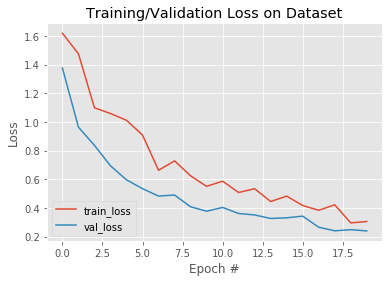

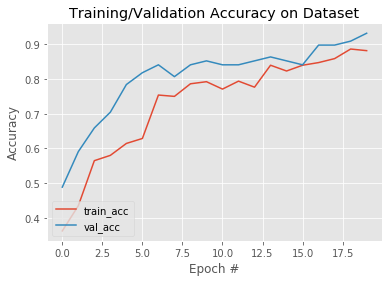

In [11]:
# Plot Results

N=NUM_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")

plt.title("Training/Validation Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot_loss.png")

plt.figure()
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")

plt.title("Training/Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [8]:
# test model

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_batches = test_datagen.flow_from_directory(DATASET_PATH + '/test',
                                                target_size=IMAGE_SIZE,
                                                interpolation='bicubic',
                                                class_mode='categorical',
                                                shuffle=False,
                                                batch_size=1)

out = model.evaluate_generator(test_batches, use_multiprocessing=True)
print(list(zip(model.metrics_names, out)))

Found 88 images belonging to 4 classes.
[('loss', 0.22705407039588657), ('accuracy', 0.89772725)]


In [9]:
test_batches.reset()
Y_pred = model.predict_generator(test_batches, use_multiprocessing=True)
# print(len(Y_pred))

In [10]:
y_pred = np.argmax(Y_pred, axis=1)

print('\n\n Classification Report\n')
target_names = list(test_batches.class_indices.keys())
print(classification_report(list(test_batches.classes), y_pred, target_names=target_names))



 Classification Report

              precision    recall  f1-score   support

   cocklebur       0.88      0.88      0.88        17
     foxtail       0.93      0.93      0.93        14
     pigweed       0.89      1.00      0.94        34
     ragweed       0.89      0.74      0.81        23

    accuracy                           0.90        88
   macro avg       0.90      0.89      0.89        88
weighted avg       0.90      0.90      0.89        88





Confusion Matrix



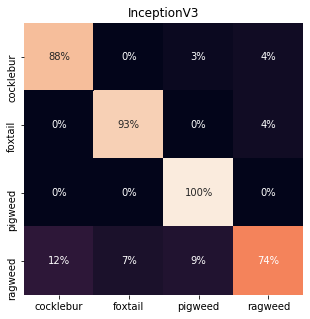

In [11]:
print('\n\nConfusion Matrix\n')
cm = confusion_matrix(test_batches.classes, y_pred)

row_sums = cm.sum(axis=1)
cm = cm / row_sums

df_cm = pd.DataFrame(cm,
                     index=['cocklebur', 'foxtail', 'pigweed', 'ragweed'],
                     columns=['cocklebur', 'foxtail', 'pigweed', 'ragweed'])
# print(df_cm)

# flights = df_cm.pivot("month", "year", "passengers")

plt.figure(figsize=(5, 5))
plt.title('InceptionV3')
sn.heatmap(df_cm, annot=True, fmt='0.0%', cbar=False)
plt.savefig('IncepV3.png')